# General
- Baseline with naive solution Xresnet34
- Best Acc: 68

In [1]:
# import pkg_resources

# def placeholder(x):
#     raise pkg_resources.DistributionNotFound
# pkg_resources.get_distribution = placeholder

# !pip uninstall fastai fastcore torchaudio -y
# #!pip install torch==1.8.1 torchaudio==0.8.1 fastcore==1.3.20
# !pip install torch==1.9.0 torchaudio==0.9.0
# !pip install fastaudio

In [2]:
# try:
#     import pycaret
# except:
#     !pip install pycaret-nightly

In [3]:
import os
import librosa
from tqdm import tqdm

import modin.pandas as pd
from fastaudio.all import *
from fastai.vision.all import *

import torch
import fastcore
import fastai
import torchaudio
torchaudio.set_audio_backend("sox_io")

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

------------------------------------------------------
# EDA

In [4]:
# CONFIGURATIONS
DATA_DIR = Path('../../input/birdclef-2022/train_audio')

In [5]:
audio_fns = get_audio_files(DATA_DIR)
print(f'No. of audio files: {len(audio_fns)}')

# to save time, I subset training data
meta_df = pd.read_csv('../../input/birdclef-2022/train_metadata.csv')
test_df = pd.read_csv('../../input/birdclef-2022/test.csv')

No. of audio files: 14852


--------------------------------------------
# Analyzing Meta Data

In [6]:
meta_df.head().T.style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
primary_label,afrsil1,afrsil1,afrsil1,afrsil1,afrsil1
secondary_labels,[],"['houspa', 'redava', 'zebdov']",[],[],[]
type,"['call', 'flight call']",['call'],"['call', 'song']","['alarm call', 'call']",['flight call']
latitude,12.391000,19.880100,16.290100,17.092200,21.458100
longitude,-1.493000,-155.725400,-16.032100,54.295800,-157.725200
scientific_name,Euodice cantans,Euodice cantans,Euodice cantans,Euodice cantans,Euodice cantans
common_name,African Silverbill,African Silverbill,African Silverbill,African Silverbill,African Silverbill
author,Bram Piot,Dan Lane,Bram Piot,Oscar Campbell,Ross Gallardy
license,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0
rating,2.500000,3.500000,4.000000,4.000000,3.000000


In [7]:
train_df = meta_df.drop(['url','filename','scientific_name','license','time','common_name','secondary_labels']
                        ,axis=1
                        ,errors='ignore')
# train_df = train_df.sample(1000)

In [8]:
enc_list = ['primary_label','author','type']
for feature in enc_list:
    le = LabelEncoder()
    le = le.fit(train_df[feature])
    train_df[feature] = le.transform(train_df[feature])

------------------------------------------------------------------------
# Understaning Metadata from the simple model

In [9]:
from pycaret.classification import *

In [10]:
setup(data = train_df, 
      target = 'primary_label',
      preprocess = True,
      silent = True
     )

,Description,Value
0,session_id,1470
1,Target,primary_label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(14852, 6)"
5,Missing Values,0
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


('f090',
 None,
 None,
 True,
 [('Setup Config',
                                  Description             Value
   0                               session_id              1470
   1                                   Target     primary_label
   2                              Target Type        Multiclass
   3                            Label Encoded              None
   4                            Original Data        (14852, 6)
   5                           Missing Values             False
   6                         Numeric Features                 5
   7                     Categorical Features                 0
   8                         Ordinal Features             False
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set        (10396, 5)
   12                    Transformed Test Set         (4456, 5)
   13                      Shuffle Train-Test          

In [11]:
dt = create_model('dt',verbose = False)

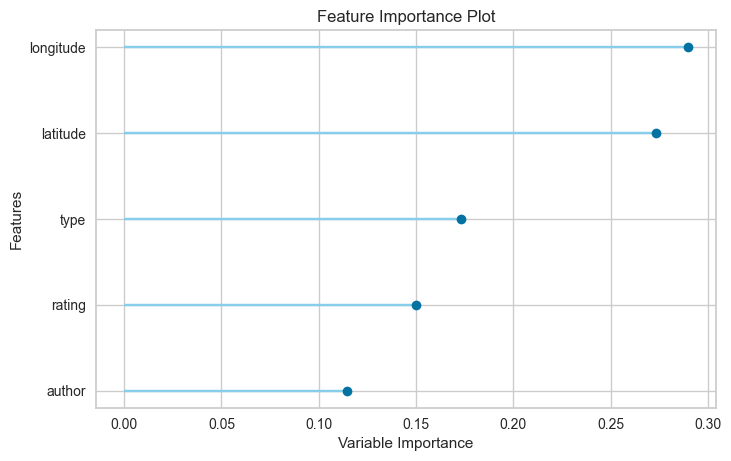

In [12]:
plot_model(dt, plot='feature')

------------------------------------
# Understanding Train Dataset

Train data are audio files. Let's hear it for ourselves and see the waveform to see what strategy can solve this problem.

In [13]:
def show_bird(audios):
    for fn in audios:
        audio = AudioTensor.create(fn)
        audio.show()

In [14]:
# aud2mfcc = AudioToMFCC(sample_rate = 32000, n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':512,'n_mels':128, 'f_min':20})
aud2mfcc = AudioToMFCC(n_mfcc=64, melkwargs={'n_fft':2048, 'hop_length':256, 'n_mels':128})
# DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

# aud2spec = DBMelSpec(n_mels=128, f_max=10000, n_fft=2048, hop_length=256)

## Making Pipeline

We build the pipeline in the following order.
> Resample -> DownmixMono -> RemoveSilence -> ResizeSignal -> AudioToMFCC -> Delta -> ToTensor

In [15]:
item_tfms = [RemoveSilence(),ResizeSignal(5000), aud2mfcc, Delta()]
# item_tfms = [RemoveSilence(), ResizeSignal(2000), aud2mfcc]
# batch_tfms = [Normalize()]

In [16]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
#                  batch_tfms=batch_tfms,
                 get_y=parent_label)

In [17]:
aud_digit.summary(DATA_DIR)

Setting-up type transforms pipelines
Found 14852 items
2 datasets of sizes 11882,2970
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      ../../input/birdclef-2022/train_audio/normoc/XC320710.ogg
    applying partial gives
      AudioTensor of size 2x1316571
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../../input/birdclef-2022/train_audio/normoc/XC320710.ogg
    applying parent_label gives
      normoc
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(96)

Final sample: (AudioTensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ..., -1.5259e-03,
         -9.1553e-05,  5.7983e-04],
        [ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
          9.7656e-04,  1.0071e-03]]), TensorCategory(96))


Found 14852 items
2 datasets 

In [18]:
dls = aud_digit.dataloaders(DATA_DIR, bs=16, num_workers=16)

In [19]:
dls.c

152

<span style="color:Blue"> Observation:
    
* Target is composed of 152 classes.

--------------------------------------------------------------------
## Checking batch

<Figure size 720x576 with 0 Axes>

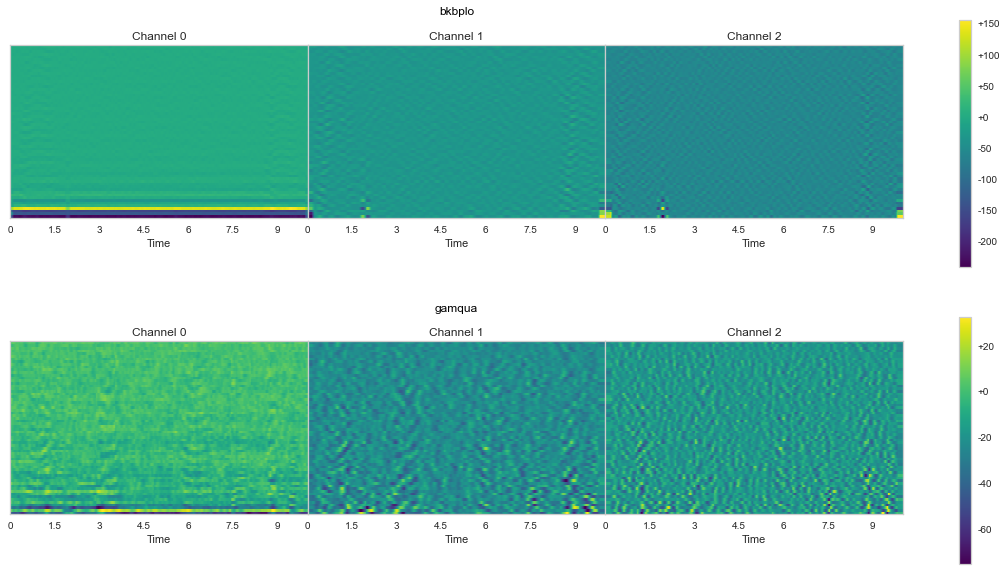

In [20]:
plt.figure(figsize=(10, 8))
dls.show_batch(max_n=3,figsize=(20,10))

------------------------------------------------------
# Modeling

In [21]:
def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  learn = Learner(dls, arch, loss_func, metrics=metrics, 
                  cbs = [EarlyStoppingCallback(monitor='accuracy', patience=5),ActivationStats(with_hist=True)]).to_fp16()
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: alter_learner(learn)
  return learn

In [22]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0')
# model._fc = nn.Linear(1280, dls.c)

learn = audio_learner(dls, 
                      xresnet34(), 
                      LabelSmoothingCrossEntropy(), 
                      accuracy)

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=1.5848932266235352)

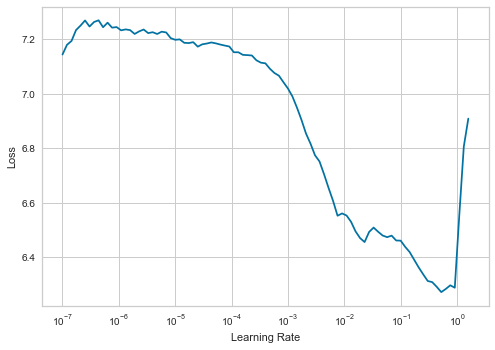

In [23]:
sr = learn.lr_find()
sr

------------------------------------------------
# Training

In [24]:
learn.fit_one_cycle(20, lr_max=slice(5e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.212981,4.343730,0.181818,08:39
1,3.934136,4.726113,0.166330,08:34
2,3.605939,3.857370,0.298653,09:09
3,3.321876,3.774098,0.347138,09:13
4,3.167170,3.976463,0.334007,09:08
5,3.057927,3.355957,0.410438,09:34
6,2.921077,3.284987,0.455219,09:22
7,2.783773,3.078959,0.509091,08:56
8,2.647361,2.979784,0.513131,09:19
9,2.549213,2.817739,0.569697,09:25


/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitemetric/anaconda3/envs/

-------------------------------------------
# Interpreting Model

In [25]:
def plot_layer_stats(self, idx):
    plt,axs = subplots(1, 3, figsize=(15,3))
    plt.subplots_adjust(wspace=0.5)
    for o,ax,title in zip(self.layer_stats(idx),axs,('mean','std','% near zero')):
        ax.plot(o)
        ax.set_title(title)

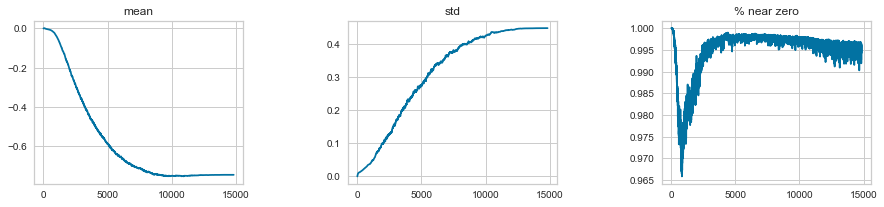

In [26]:
plot_layer_stats(learn.activation_stats,-2)

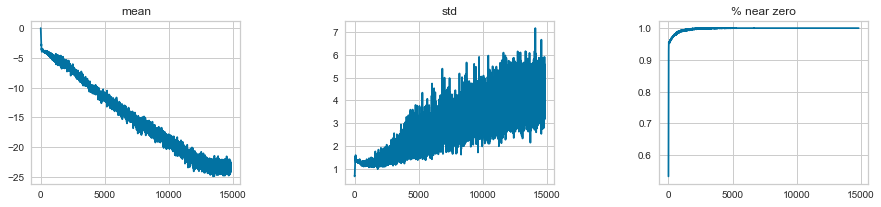

In [27]:
plot_layer_stats(learn.activation_stats,-1)

<span style="color:Blue"> Observation:
* The activation distribution is well distributed.

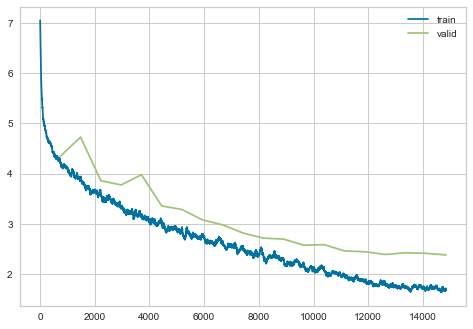

In [28]:
learn.recorder.plot_loss()

In [29]:
learn.save('xresnet34-stage1-before-unfreeze-68')

Path('models/xresnet34-stage1-before-unfreeze-68.pth')

<span style="color:Blue"> Observation:
* It seems that learning has ended before overffing. However, I still don't know if it is the optimal point. It is burdensome to increase the epoch because the training time is too long.

----------------------------------------------
# Checking Results

<span style="color:Blue"> Observation:
* Because there are many classes of Target, it is not good to look at.
* If you look at the diagonal of the matrix, it seems that it has learned to some extent. However, it is not satisfactory.

**Let's check the cases where the model made the most mistakes!**

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=10)

[]

<span style="color:Blue"> Observation:
* In the combination of 'bcnher' and 'brnowl', there are many cases where the judgment is exceptionally wrong. I guess I'll have to check more on why. 

# Unfreeze and retrain model

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(20, lr_max=slice(5e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.679822,2.396994,0.677778,08:38
1,1.714211,2.395777,0.673737,08:44
2,1.848671,2.438301,0.680135,08:37
3,1.733298,2.526163,0.658586,08:43
4,1.708925,2.523436,0.661279,08:38
5,1.827967,2.520822,0.647475,08:43
6,1.743701,2.559190,0.653535,08:47
7,1.786494,2.533025,0.661616,08:50


No improvement since epoch 2: early stopping


In [34]:
learn.save('xresnet34-stage2-after-unfreeze')

Path('models/xresnet34-stage2-after-unfreeze.pth')